In [1]:
import json
import random
import time
from multiprocessing import Pool
from pathlib import Path

import requests
from tqdm import tqdm

# run on original files

In [ ]:
file_names = json.loads(Path("filelist.json").read_text())
print(len(file_names))
random.seed(42)
file_names = random.sample(file_names, 10_000)
file_names = Path("res_out")

path_8k = Path("wav8k")
path_16k = Path("wav16k")

file_names_8k = [path_8k / f for f in file_names]
file_names_16k = [path_16k / f for f in file_names]

file_names_8k = sorted(file_names_8k, key=lambda f: f.stat().st_size)
file_names_16k = sorted(file_names_16k, key=lambda f: f.stat().st_size)

71814


In [3]:
def run_asr(file_path):
    try:
        am_response = requests.get("http://192.168.1.106:8080/predictions/acoustic_model", data=open(file_path, "rb"))
        asr_response = requests.get("http://192.168.1.106:8080/predictions/asr_decoder", data=am_response.text)
        # am_response = requests.get("http://192.168.1.125:8080/predictions/acoustic_model", data=open(file_path, "rb"))
        # asr_response = requests.get("http://192.168.1.125:8080/predictions/asr_decoder", data=am_response.text)
        return file_path, asr_response.text
    except:
        return file_names, "Exception occurred"

In [4]:
run_asr(path_8k / file_names[0]), run_asr(path_16k / file_names[0])

((PosixPath('wav8k/common_voice_en_19023347.wav'),
  'THE PRINCE WAS NAMED AFTER SOME LAW OF ROSA THE KING OF MEDIEVAL CROSS'),
 (PosixPath('wav16k/common_voice_en_19023347.wav'),
  'THE PRINCE WAS NAMED AFTER THOMAS LAW OF COROT THE KING OF MEDIEVAL CROSS'))

In [5]:
with open("/tmp/tmp.json", "w") as f:
    json.dump(file_names, f)

In [6]:
with Pool(20) as p:
    results_8k = []
    for result in tqdm(p.imap_unordered(run_asr, file_names_8k), total=len(file_names_8k)):
        results_8k.append(result)
    results_16k = []
    for result in tqdm(p.imap_unordered(run_asr, file_names_16k), total=len(file_names_16k)):
        results_16k.append(result)


100%|██████████| 10000/10000 [16:21<00:00, 10.19it/s]


In [7]:
with open("results_8k.json", "w") as f:
    json.dump([(str(i), j) for i, j in results_8k], f, indent=4)
with open("results_16k.json", "w") as f:
    json.dump([(str(i), j) for i, j in results_16k], f, indent=4)


# enhance

In [8]:
import torch
from torch import nn
import torch.nn.functional as F


class ResNetBlock1D(nn.Module):
    def __init__(self, channels, kernel_size=3, dilation=1):
        super().__init__()
        padding = (kernel_size - 1) // 2 * dilation
        self.block = nn.Sequential(
            nn.Conv1d(channels, channels, kernel_size, padding=padding, dilation=dilation),
            nn.BatchNorm1d(channels),
            nn.ReLU(),
            nn.Conv1d(channels, channels, kernel_size, padding=padding, dilation=dilation),
            nn.BatchNorm1d(channels),
        )
        self.activation = nn.ReLU()

    def forward(self, x):
        return self.activation(x + self.block(x))


class AudioUNet(nn.Module):
    def __init__(self, in_channels=1, base_channels=64, num_layers=4):
        super().__init__()
        self.num_layers = num_layers

        # Encoder
        self.encoders = nn.ModuleList()
        self.downsamplers = nn.ModuleList()
        in_ch = in_channels
        for i in range(num_layers):
            out_ch = base_channels * (2 ** i)
            self.downsamplers.append(nn.Conv1d(in_ch, out_ch, kernel_size=4, stride=2, padding=1))
            self.encoders.append(nn.Sequential(*[ResNetBlock1D(out_ch) for _ in range(3)]))
            in_ch = out_ch

        # Bottleneck
        self.bottleneck = nn.Sequential(*[ResNetBlock1D(in_ch) for _ in range(3)])

        # Decoder
        self.upsamplers = nn.ModuleList()
        self.decoders = nn.ModuleList()
        for i in reversed(range(num_layers)):
            out_ch = base_channels * (2 ** i)
            self.upsamplers.append(
                nn.ConvTranspose1d(in_ch, out_ch, kernel_size=4, stride=2, padding=1)
            )
            self.decoders.append(nn.Sequential(*[ResNetBlock1D(out_ch) for _ in range(3)]))
            in_ch = out_ch

        # Output layer
        self.output_conv = nn.Sequential(
            nn.ConvTranspose1d(base_channels, base_channels, kernel_size=4, stride=2, padding=1),
            nn.Conv1d(base_channels, 1, kernel_size=1),
        )
        self.activation = nn.Tanh()

    def forward(self, x):
        skips = []

        # Encoder path
        for down, enc in zip(self.downsamplers, self.encoders):
            x = down(x)
            x = enc(x)
            skips.append(x)

        # Bottleneck
        x = self.bottleneck(x)

        # Decoder path
        for up, dec, skip in zip(self.upsamplers, self.decoders, reversed(skips)):
            x = up(x)
            # In case of mismatch due to rounding in downsampling
            if x.shape[-1] != skip.shape[-1]:
                x = F.pad(x, (0, skip.shape[-1] - x.shape[-1]))
            x = x + skip
            x = dec(x)

        # Output
        return self.activation(self.output_conv(x))


In [9]:
device = torch.device("cuda", index=0)
model = AudioUNet().to(device)

model.load_state_dict(torch.load("model_epoch0037.pth"))

<All keys matched successfully>

In [10]:
import io

import torchaudio

results_enhanced = []
for file_path in tqdm(file_names_8k):
    x, fs = torchaudio.load(file_path)
    x = x.to(device)
    x = x.unsqueeze(0)
    x = model(x)
    x = x.squeeze(0)
    x = x.cpu()
    in_memory_file = io.BytesIO()
    torchaudio.save(in_memory_file, x, fs, format="wav")
    in_memory_file.seek(0)
    am_response = requests.get("http://192.168.1.106:8080/predictions/acoustic_model", data=in_memory_file)
    asr_response = requests.get("http://192.168.1.106:8080/predictions/asr_decoder", data=am_response.text)
    results_enhanced.append((file_path, asr_response.text))

100%|██████████| 10000/10000 [27:54<00:00,  5.97it/s]


In [11]:
with open("results_enhance.json", "w") as f:
    json.dump([(str(i), j) for i, j in results_enhanced], f, indent=4)

# load GT

In [12]:
agg_dataset = json.loads(Path("/home/aj/repo/baden_asr/train_dataset_aggregation.json").read_text())
mozilla_dataset = {Path(item["path"]).name: item["sentence"] for item in tqdm(agg_dataset) if "common_voice_en" in item["path"]}

100%|██████████| 2942080/2942080 [00:02<00:00, 1302890.06it/s]


In [13]:
file_names[0], mozilla_dataset[file_names[0]]

('common_voice_en_19023347.wav',
 'THE PRINCE WAS NAMED AFTER TOMISLAV OF CROATIA THE KING OF MEDIEVAL CROATIA')

# compare the results

In [14]:
text8k = [i for _, i in sorted(results_8k, key=lambda x: file_names.index(x[0].name))]
text_enhanced = [i for _, i in sorted(results_enhanced, key=lambda x: file_names.index(x[0].name))]
text16k = [i for _, i in sorted(results_16k, key=lambda x: file_names.index(x[0].name))]
target = [mozilla_dataset[file_name] for file_name in file_names]

In [15]:
list(zip(text8k[:3], text_enhanced[:3], text16k[:3], target[:3]))

[('THE PRINCE WAS NAMED AFTER SOME LAW OF ROSA THE KING OF MEDIEVAL CROSS',
  'THE PRINCE WAS NAMED AFTER SOME LAW OF CROSSI THE KING OF MEDIEVAL CROSSI',
  'THE PRINCE WAS NAMED AFTER THOMAS LAW OF COROT THE KING OF MEDIEVAL CROSS',
  'THE PRINCE WAS NAMED AFTER TOMISLAV OF CROATIA THE KING OF MEDIEVAL CROATIA'),
 ('THE THEATER IS CLOSED FOR RENOVATIONS BUT WILL REOPEN IN TWENTY NINETEEN',
  'THE FUTURE IS CLOSED FOR RENOVATIONS BUT WERE HE TWENTY MAINTAINED',
  'THE THEATER IS CLOSED FOR RENOVATIONS BUT WILL REOPEN IN TWENTY NINETEEN',
  'THE THEATER IS CLOSED FOR RENOVATIONS BUT WILL REOPEN IN TWENTY NINETEEN'),
 ('DOG TRAINING BY TUG IS A TOOL USUALLY USED AS A RETRIEVED DEVELOPING SKILL',
  'DOG TRAINING BY TUG IS A TOOL USUALLY USED AS A TRIVET DEVELOPING SKILL',
  'DOG TRAINING BY TUG IS A TOOL USUALLY USED AS RETRIEVED DEVELOPING SKILL',
  'DOG TRAINING BITE TUG IS A TOOL USUALLY USED AS RETRIEVE DEVELOPING SKILLS')]

In [16]:
from torchmetrics.text import CharErrorRate, WordErrorRate

cer, wer = CharErrorRate(), WordErrorRate()

cer8k = cer(text8k, target)
cerenhance = cer(text_enhanced, target)
cer16k = cer(text16k, target)

wer8k = wer(text8k, target)
werenhance = wer(text_enhanced, target)
wer16k = wer(text16k, target)

In [17]:
print(round(cer8k.item(), 5), round(cerenhance.item(), 5), round(cer16k.item(), 5))
print(round(wer8k.item(), 5), round(werenhance.item(), 5), round(wer16k.item(), 5))

0.04698 0.08233 0.03472
0.11839 0.17449 0.09626


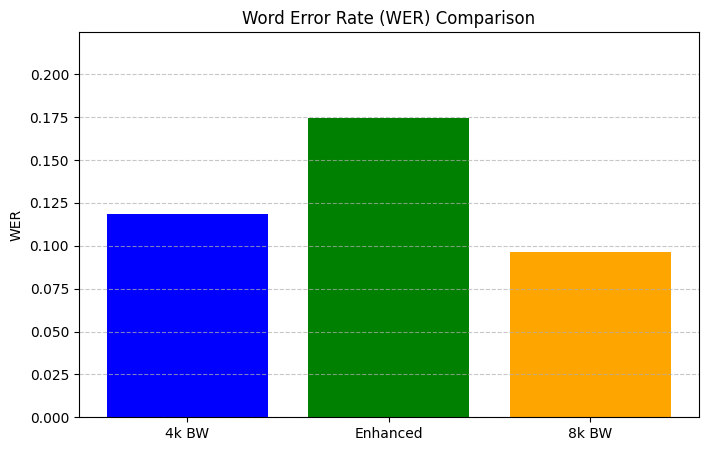

In [18]:
import matplotlib.pyplot as plt

# WER values
wer_values = [wer8k.item(), werenhance.item(), wer16k.item()]
labels = ['4k BW', 'Enhanced', '8k BW']

# Plot
plt.figure(figsize=(8, 5))
plt.bar(labels, wer_values, color=['blue', 'green', 'orange'])
plt.title('Word Error Rate (WER) Comparison')
plt.ylabel('WER')
plt.ylim(0, max(wer_values) + 0.05)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [19]:
Path("common_voice_en_19796797.wav").write_bytes(in_memory_file.getbuffer())

329358